# Car prices determining

Used cars sale service "Not beaten, not beautiful" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. At your disposal are historical data: technical specifications, equipment and prices of cars. You need to build a model to determine the cost.

Important points for the customer:

- prediction quality;
- prediction speed;
- studying time.

## Initial processing

### Initial evaluation

First you need to download the necessary libraries for data processing.

In [301]:
import os
import time

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt
from IPython.display import display
from numpy.random import RandomState
from math import sqrt



from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error as mse

PATH = '/datasets/'
SEED = 12345

As well as dataframes with data.

In [302]:
df = pd.read_csv(os.path.join(PATH, 'autos.csv'),
                   parse_dates=['DateCrawled', 'LastSeen', 'DateCreated'])

Distribution Estimation

I proceed to the primary researching "at a glance" in order to understand the sequence of actions.

In [303]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null datetime64[ns]
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.3+ MB


In [304]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
28958,2016-03-07 23:48:15,6290,wagon,2007,manual,143,6_reihe,125000,9,gasoline,mazda,no,2016-03-07,0,42555,2016-03-19 23:47:11
202047,2016-03-22 00:58:56,350,NaN,2000,manual,0,2_reihe,150000,0,petrol,peugeot,NaN,2016-03-21,0,82276,2016-03-29 09:45:51
156517,2016-03-19 15:57:09,1400,bus,1999,manual,101,NaN,150000,0,petrol,opel,no,2016-03-19,0,66482,2016-03-19 15:57:09
64311,2016-03-05 18:57:28,6500,small,2012,manual,75,other,70000,6,gasoline,hyundai,no,2016-03-05,0,37115,2016-03-17 18:17:13
296643,2016-03-07 13:36:42,7999,sedan,2005,auto,177,a6,125000,3,petrol,audi,no,2016-03-07,0,49084,2016-03-12 10:55:01


In [305]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


The information is researched, useful conclusions for preprocessing are made.
* The NumberOfPictures column does not carry useful information for the model, all rows are filled with zeros. It needs to be removed.
* The DateCrawled column duplicates the values ​​of the DateCreated column.
* The RegistrationMonth item does not affect the cost estimate.
* The LastSeen parameter also does not affect the valuation.
* Perhaps the PostalCode parameter can be tied to a territorial mark, but this requires an additional dataframe with information about the correspondence of postal codes and cities, which I do not have on assignment. I will remove this column so that the models do not perceive this parameter as an integer object.
 
I'm going to preprocess.


Delete the above columns.

In [306]:
df = df.drop(['NumberOfPictures', 'DateCrawled', 'RegistrationMonth', 'LastSeen', 'PostalCode'], axis=1)

Separate categorical features from numerical ones.

In [307]:
numerical_features = ['DateCreated', 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'LastSeen']
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']

Evaluation of the distribution of numerical features.

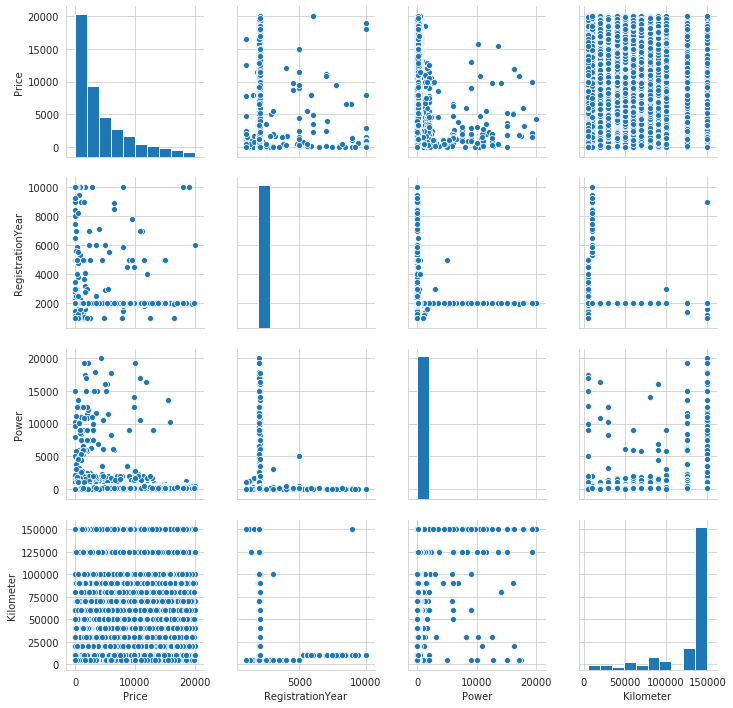

In [308]:
sns.pairplot(df)

I remove gaps, outliers and duplicates. I start with complete duplicates.

In [309]:
df = df.drop_duplicates()

I process each feature separately.

### Price

First, an estimate of the distribution.

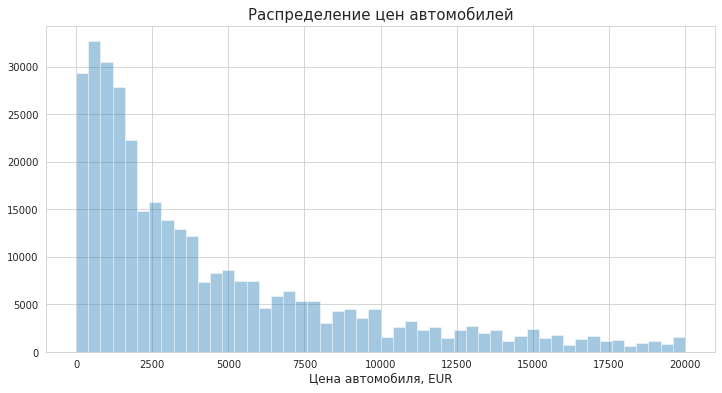

In [310]:
sns.set_style('whitegrid')

plt.figure(figsize=(12,6))
sns.distplot(df['Price'], kde=False)

plt.xlabel('Цена автомобиля, EUR', size=12)
plt.title('Распределение цен автомобилей', size=15);

A large number of null values ​​have been recorded. I will count them.

In [311]:
f"Объявления с нулевой ценой: {len(df.loc[df['Price'] == 0])}"

'Объявления с нулевой ценой: 10399'

I will remove them from the dataframe for lack of value.

In [312]:
df = df.loc[df['Price'] != 0]

### Model

For further work, do not carry the meaning of the line, where there is no information about the model. I will count them.

In [313]:
f"Незаполненных строк с моделями: {len(df.loc[df['Model'].isna()])}"

'Незаполненных строк с моделями: 17244'

And I will delete them.

In [314]:
df = df.loc[~df['Model'].isna()]

### Power

The maximum power of the car at the time of the researching is 1360 hp. Delete all values ​​above this mark.

In [315]:
f"Автомобили с мощностью > 1360 л.с.: {len(df.loc[(df['Power'] > 1360) | (df['Power'] <= 0)])}"

'Автомобили с мощностью > 1360 л.с.: 30411'

I change these values by medians according to the same model.

In [316]:
df.loc[(df['Power'] > 1000) | (df['Power'] <= 0), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df = df.loc[~df['Power'].isna()]
df['Power'] = df['Power'].astype('int64')

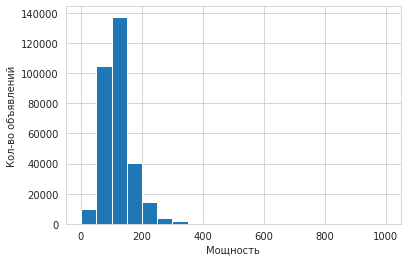

In [317]:
plt.hist(df['Power'], bins=20)
plt.ylabel('Кол-во объявлений')
plt.xlabel('Мощность');

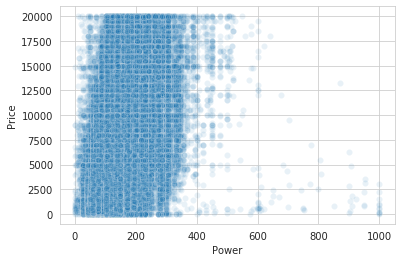

In [318]:
sns.scatterplot(x='Power', y='Price', data=df, alpha = 0.1)

### DateCreated 

In [319]:
f"Дата первого объявления: {min(df['DateCreated'])}"

'Дата первого объявления: 2014-03-10 00:00:00'

Let's convert this feature to the number of days since the publication of the first ad in the selection to take into account the time feature.

In [320]:
base_date = pd.Timestamp('2014-03-01 00:00:00')
df['DateCreated'] = df['DateCreated'].map(lambda date : (pd.Timestamp(date) - base_date).days)

### VehicleType, Gearbox, FuelType

Missing values for these traits are likely to be the same for all machines of the same model. I'll make a replacement.

In [321]:
df['VehicleType'] = df['VehicleType'].fillna(df
                                                  .groupby('Model')['VehicleType']
                                                  .transform(lambda x: x.value_counts().idxmax())
                                                 )

df['Gearbox'] = df['Gearbox'].fillna(df
                                         .groupby('Model')['VehicleType']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

df['FuelType'] = df['FuelType'].fillna(df
                                           .groupby('Model')['VehicleType']
                                           .transform(lambda x: x.value_counts().idxmax())
                                          )

### NotRepaired

In [322]:
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

### Score after filling in gaps

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313353 entries, 0 to 354368
Data columns (total 11 columns):
Price               313353 non-null int64
VehicleType         313353 non-null object
RegistrationYear    313353 non-null int64
Gearbox             313353 non-null object
Power               313353 non-null int64
Model               313353 non-null object
Kilometer           313353 non-null int64
FuelType            313353 non-null object
Brand               313353 non-null object
NotRepaired         313353 non-null object
DateCreated         313353 non-null int64
dtypes: int64(5), object(6)
memory usage: 28.7+ MB


In [324]:
df.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated
0,480,sedan,1993,manual,101,golf,150000,petrol,volkswagen,unknown,754
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,744
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,747
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,761
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,765
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,762
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown,765
9,999,small,1998,manual,101,golf,150000,sedan,volkswagen,unknown,747
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no,756
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes,768


I’m moving on to the processing of categorical features.

### Model/Brand

I will combine and encode these two features.

In [325]:
df['brand_model'] = df['Brand'].astype(str) + ' ' + df['Model'].astype(str)
df['model_code'] = df['brand_model'].map(df.groupby('brand_model').size()) / \
                     df['Brand'].map(df.groupby('Brand').size())
df_coded = df.drop(['brand_model', 'Brand', 'Model'], axis=1)

### VehicleType, Gearbox, FuelType, NotRepaired: OHE

In [326]:
def get_dummies_func(data, column, prefix):
    df = pd.get_dummies(data[column], prefix=prefix, drop_first=True)
    data = data.drop(column, axis=1)
    return data.join(df)

In [327]:
df_coded = get_dummies_func(df_coded, 'VehicleType', 'VType')

df_coded = get_dummies_func(df_coded, 'Gearbox', 'Gear')

df_coded = get_dummies_func(df_coded, 'FuelType', 'Fuel')

df_coded = get_dummies_func(df_coded, 'NotRepaired', 'Repair')

In [328]:
df_coded.head(5)

,Price,RegistrationYear,Power,Kilometer,DateCreated,model_code,VType_convertible,VType_coupe,VType_other,VType_sedan,...,Fuel_hybrid,Fuel_lpg,Fuel_other,Fuel_petrol,Fuel_sedan,Fuel_small,Fuel_suv,Fuel_wagon,Repair_unknown,Repair_yes
0,480,1993,101,150000,754,0.395955,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,9800,2004,163,125000,744,0.371336,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,747,0.395955,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,3600,2008,69,90000,761,0.388508,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,765,0.562308,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1


### Preparing samples

I determine the target feature and divide the sample into training and test in a ratio of 4:1.

In [329]:
X = df_coded.drop('Price', axis=1)
y = df_coded['Price']

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [331]:
print('Размер обучающей выборки:',X_train.shape[0])

Размер обучающей выборки: 250682


In [332]:
print('Размер тестовой выборки:',X_test.shape[0])

Размер тестовой выборки: 62671


### Scaling features to the standard normal distribution

In [333]:
stsc = StandardScaler()
stsc.fit(X_train)
columns = X_train.columns
X_train = pd.DataFrame(stsc.transform(X_train), columns = columns)
X_test = pd.DataFrame(stsc.transform(X_test), columns = columns)

In [334]:
X_train.head(5)

,RegistrationYear,Power,Kilometer,DateCreated,model_code,VType_convertible,VType_coupe,VType_other,VType_sedan,VType_small,...,Fuel_hybrid,Fuel_lpg,Fuel_other,Fuel_petrol,Fuel_sedan,Fuel_small,Fuel_suv,Fuel_wagon,Repair_unknown,Repair_yes
0,-0.075889,-0.337874,0.578887,-1.678557,0.887388,-0.250774,-0.221601,-0.091913,-0.66093,1.709276,...,-0.024874,-0.122732,-0.018417,0.780132,-0.186131,-0.145957,-0.033796,-0.105395,-0.470149,3.017903
1,-0.013709,-0.262699,-0.771812,-0.511251,0.887388,-0.250774,-0.221601,-0.091913,1.51302,-0.585043,...,-0.024874,-0.122732,-0.018417,0.780132,-0.186131,-0.145957,-0.033796,-0.105395,-0.470149,-0.331356
2,-0.075889,-0.450637,0.578887,1.505004,-0.587929,-0.250774,-0.221601,-0.091913,-0.66093,1.709276,...,-0.024874,-0.122732,-0.018417,-1.281834,-0.186131,-0.145957,-0.033796,-0.105395,-0.470149,-0.331356
3,-0.029254,0.958902,0.578887,-0.086776,-0.255931,-0.250774,-0.221601,-0.091913,1.51302,-0.585043,...,-0.024874,-0.122732,-0.018417,0.780132,-0.186131,-0.145957,-0.033796,-0.105395,-0.470149,3.017903
4,-0.122523,-0.544607,0.578887,-0.086776,-0.328799,-0.250774,4.512619,-0.091913,-0.66093,-0.585043,...,-0.024874,-0.122732,-0.018417,0.780132,-0.186131,-0.145957,-0.033796,-0.105395,-0.470149,-0.331356


### Conclusion:

* Libraries and data loaded
* Removed features that do not carry value for the model
* Removed duplicates
* Filled in missing values
* Some invalid values removed
* Categorical features converted by one-hot encoding
* Data is divided into training and test sets
* Carried out standardization

The samples are ready for model training.

## Models training

I create a model that predicts averages to compare with it really working.

In [335]:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(X_train, y_train)
predictions_r_dummy = dummy_regr.predict(X_test)
print('RMSE dummy:', rmse(y_test, predictions_r_dummy))

RMSE dummy: 4544.665247219124


### Linear regression

First, I will test the linear regression trained by the cross-validation method. I will calculate the speed of the model at the stage of training and prediction, and evaluate its quality by RMSE.

In [336]:
%%time
lr = LinearRegression()
mse = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

CPU times: user 4.18 s, sys: 1.34 s, total: 5.52 s
Wall time: 5.49 s


In [337]:
f"RMSE для линейной модели на валидационной выборке: {round((-mse.mean()) ** 0.5, 2)}"

'RMSE для линейной модели на валидационной выборке: 3101.46'

In [338]:
%%time
lr.fit(X_train, y_train)

CPU times: user 902 ms, sys: 184 ms, total: 1.09 s
Wall time: 1.1 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [339]:
%%time
preds_lr = lr.predict(X_test)

CPU times: user 18 ms, sys: 4.1 ms, total: 22.1 ms
Wall time: 5.94 ms


In [340]:
mse_lr = mean_squared_error(y_test, preds_lr)
f"RMSE для линейной модели на тестовой выборке: {round((mse_lr) ** 0.5, 2)}"

'RMSE для линейной модели на тестовой выборке: 3109.05'

### Gradient Boosting

Now I will test the gradient boosting from the sklearn library.

In [341]:
%%time
gbr = GradientBoostingRegressor(random_state=SEED)

mse = cross_val_score(gbr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

CPU times: user 2min 26s, sys: 183 ms, total: 2min 26s
Wall time: 2min 27s


In [342]:
f"RMSE для градиентного бустинга из sklearn на валидационной выборке: {round((-mse.mean()) ** 0.5, 2)}"

'RMSE для градиентного бустинга из sklearn на валидационной выборке: 2005.72'

In [343]:
%%time
gbr.fit(X_train, y_train)

CPU times: user 37.5 s, sys: 66.5 ms, total: 37.5 s
Wall time: 38.1 s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=12345, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [344]:
%%time
preds_gbr = gbr.predict(X_test)

CPU times: user 133 ms, sys: 24 µs, total: 133 ms
Wall time: 147 ms


In [345]:
mse_gbr = mean_squared_error(y_test, preds_gbr)
f"RMSE градиентного бустинга sklearn на тестовой выборке: {round((mse_gbr) ** 0.5, 2)}"

'RMSE градиентного бустинга sklearn на тестовой выборке: 2024.58'

### LightGBM

Testing the gradient boosting model specified in the assignment.

In [346]:
numerical_features = ['DateCreated', 'Price', 'RegistrationYear', 'Power', 'Kilometer']
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']

In [347]:
df = df.drop(['brand_model', 'model_code'], axis=1)

In [348]:
X = df_coded.drop('Price', axis=1)
y = df_coded['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [349]:
f"Размер обучающей выборки: {X_train.shape[0]}"

'Размер обучающей выборки: 250682'

In [350]:
f"Размер тестовой выборки: {X_test.shape[0]}"

'Размер тестовой выборки: 62671'

In [351]:
categorical_features = [col for col in list(df_coded.columns) if col not in numerical_features]

In [352]:
%%time
train_data = lightgbm.Dataset(X_train, label=y_train, 
                              free_raw_data=False,
                              categorical_feature=categorical_features)
test_data = lightgbm.Dataset(X_test, label=y_test)

param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [15, 20, 30, 35],
             }

lgbm = lightgbm.LGBMRegressor(n_jobs = 8)

grid_search = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                          )
grid_search.fit(X_train, y_train)

CPU times: user 5min 9s, sys: 2.02 s, total: 5min 12s
Wall time: 5min 16s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=8, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7],
                         'max_depth': [15, 20, 30, 35]},
             pre_dispatch='2*n_jobs', refit=True, re

In [353]:
print(grid_search.best_params_)

{'learning_rate': 0.3, 'max_depth': 20}


In [354]:
print('RMSE для LightGBM модели на валидационной выборке: {:.2f}'.format((-grid_search.best_score_) ** 0.5))

RMSE для LightGBM модели на валидационной выборке: 1694.09


In [355]:
%%time
preds_lgbm = grid_search.best_estimator_.predict(X_test)

CPU times: user 555 ms, sys: 3.91 ms, total: 558 ms
Wall time: 506 ms


In [356]:
mse_lgbm = mean_squared_error(y_test, preds_lgbm)
f"RMSE для LightGBM модели на тестовой выборке: {round((mse_lgbm) ** 0.5, 2)}"

'RMSE для LightGBM модели на тестовой выборке: 1686.28'

### Conclusion:

1. Three types of models were trained:

* Linear Regression
* Gradient Boosting from sklearn library
* LightGBM

2. The models produced their predictions
3. Measured the speed of their work
4. RMSE values ​​measured for each model


## Analysis of models

### RMSE comparison

RMSE dummy: 4544.665247219124

RMSE for a linear model on a test set: 3109.05

RMSE of sklearn gradient boosting on test set: 2024.58

RMSE for LightGBM model on test set: 1686.28



### Training time comparison

Linear Regression: 1.11s

GradientBoostingRegressor: 39.3s

LightGBM (including cross-validation): 5min 8s

### Prediction time comparison

Linear regression: 4.46 ms

GradientBoostingRegressor: 147ms

LightGBM: 581ms

## General Conclusion:

1. All models showed significantly better RMSE results than the dummy model. Their rating is as follows:
* LightGBM
* GradientBoostingRegressor
* Linear Regression

2. In terms of training time, the situation is completely reversed.
* Linear Regression
* GradientBoostingRegressor
* LightGBM

3. In terms of prediction time, the situation is the same
* Linear Regression
* GradientBoostingRegressor
* LightGBM

I recommend using the LightGBM model even at the expense of speed, as it shows the result much better than other models.